## 딥러닝응용 1주차 리포트
### 4. 3번과 동일하지만 dense layer만 사용한 신경만으로 회귀를 수행하라.

In [4]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [5]:
# Load Data
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# Data Preprocessing 
df = pd.read_csv('diabetes.csv')
x = df.drop(['Outcome', 'BMI'], axis=1)
y = df['BMI']

In [7]:
# Train-Test Split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [8]:
# Import Libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Data
df = pd.read_csv('diabetes.csv')

x = df.drop(['BMI'], axis=1).values  
y = df['BMI'].values  

# Train-Test Split + Data Normalization
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert to PyTorch Tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make it 2D for regression
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Dataset and Dataloader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# NeuralNetwork Class (Only Dense Layer)
class NeuralNetwork(nn.Module):
    def __init__(self, n_input, n_hidden):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(n_hidden, 1)  

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return x

# Hyperparameters
n_input = x_train.shape[1]   
n_hidden = 64                

# Functions
model = NeuralNetwork(n_input, n_hidden).to(device)
loss_fn = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train Function
def train(dataloader, model, loss_fn, optimizer):
    model.train() 
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


# Test Function
def test(dataloader, model, loss_fn):
    model.eval()  # Set model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():  
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:.6f} \n")

# Train + Test Loop
epochs = 200
for t in range(epochs):
    print(f"Epoch [{t+1}/{epochs}]")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
    print("-" * 30)

print("Done!")

Epoch [1/200]
Avg loss: 1070.097485 

------------------------------
Epoch [2/200]
Avg loss: 1041.198010 

------------------------------
Epoch [3/200]
Avg loss: 1010.034473 

------------------------------
Epoch [4/200]
Avg loss: 974.208850 

------------------------------
Epoch [5/200]
Avg loss: 933.581055 

------------------------------
Epoch [6/200]
Avg loss: 887.585596 

------------------------------
Epoch [7/200]
Avg loss: 835.402600 

------------------------------
Epoch [8/200]
Avg loss: 777.922656 

------------------------------
Epoch [9/200]
Avg loss: 716.193018 

------------------------------
Epoch [10/200]
Avg loss: 651.221936 

------------------------------
Epoch [11/200]
Avg loss: 582.800842 

------------------------------
Epoch [12/200]
Avg loss: 515.495062 

------------------------------
Epoch [13/200]
Avg loss: 450.745416 

------------------------------
Epoch [14/200]
Avg loss: 389.207574 

------------------------------
Epoch [15/200]
Avg loss: 332.110162 

--

Mean Squared Error (MSE): 59.4552
Mean Absolute Error (MAE): 5.3269
R² Score: 0.1636


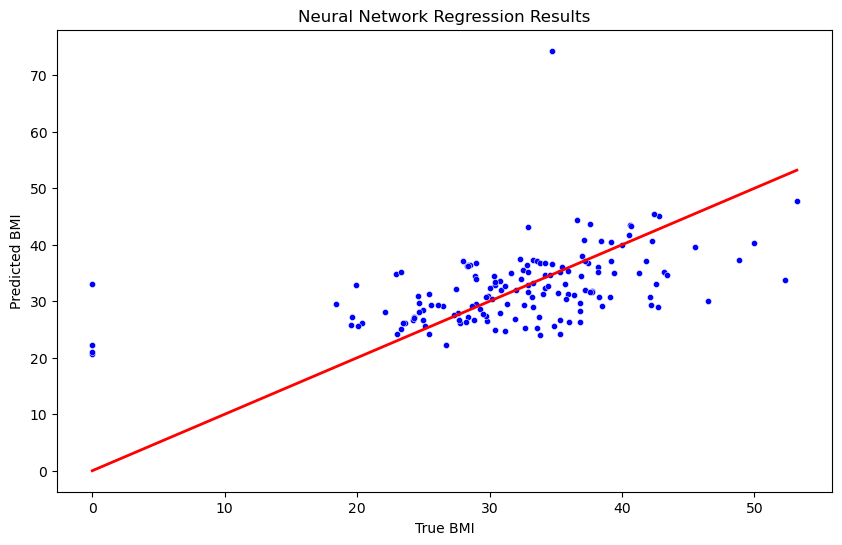

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        y_pred.extend(pred.cpu().numpy())  
        y_test.extend(y.cpu().numpy())    

# Print Measures
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

y_pred = np.array(y_pred).flatten()
y_test = np.array(y_test).flatten()

# Plot Results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2) 
plt.xlabel('True BMI')
plt.ylabel('Predicted BMI')
plt.title('Neural Network Regression Results')
plt.show()